In [1]:
### 1. Data prepare

In [19]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [3]:
def query_prom(query, startTime, endTime, PROMETHEUS = 'http://20.71.55.156:9090/', debug=False):
    response = requests.get(PROMETHEUS + '/api/v1/query_range',
      params={'query': query,
              'start': startTime,
              'end': endTime,
              'step': '15s'})
    if debug:
        print(response.json())
    results = response.json()['data']['result']
    return results

In [4]:
from prometheus_api_client import PrometheusConnect
prom = PrometheusConnect(url ="http://20.71.55.156:9090", disable_ssl=True)

# Get the list of all the metrics that the Prometheus host scrapes
metrics = prom.all_metrics()
# import pprint
# pprint.pprint(metrics)


In [5]:
startTime = 1619692800
endTime = 1619696520

startTime = 1620598279
endTime = 1620648679

startTime = 1621335960
endTime = 1621343220


In [6]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))
# print(caliper_txn_failure)

In [7]:
def caliper_df(label, startTime=startTime, endTime=endTime):
    label_data = query_prom(label, startTime, endTime, debug=False)[0]
    time = list(map(int, np.array(label_data['values'])[:,0]))
    value_t = list(map(float, np.array(label_data['values'])[:,1]))
    # transfer time from timestamp to datetime
    time_ax = []
    for each in time:
        time_ax.append(datetime.datetime.fromtimestamp(each))
    label = [0]
    for i in range(1,len(value_t)):
        if value_t[i]-value_t[i-1] != 0:
            label.append(1)
        else:
            label.append(0)
    return pd.DataFrame({'time': time_ax,'label': label})


# Caliper data for label
txn_failure = 'caliper_txn_failure'
label_data=caliper_df(txn_failure)


In [8]:
def query_data(metric):
    query = 'irate('+metric+'{device="sdb",instance="nodeexporter1",job="nodeexporter"}[5m])'
    try:
        result = query_prom(query, startTime, endTime)[0]
        value = list(map(float, np.array(result['values'])[:,1]))
        label_data[metric] = value
        return value
    except:
        pass

In [36]:
for metric in tqdm(metrics):
    query_data(metric)
# print(label_data.head())

# Proces data

In [37]:
processed_df = label_data.copy()
# processed_df.head()
bool_caliper_txn_failure = [bool(i) for i in caliper_txn_failure]

processed_df["caliper_txt_failure"] =  caliper_txn_failure

processed_df["bool_caliper_txn_failure"] =  bool_caliper_txn_failure
processed_df.drop(["bool_caliper_txn_failure", "caliper_txt_failure"], axis=1)
processed_df.head()

,time,label,node_disk_discard_time_seconds_total,node_disk_discarded_sectors_total,node_disk_discards_completed_total,node_disk_discards_merged_total,node_disk_io_now,node_disk_io_time_seconds_total,node_disk_io_time_weighted_seconds_total,node_disk_read_bytes_total,node_disk_read_time_seconds_total,node_disk_reads_completed_total,node_disk_reads_merged_total,node_disk_write_time_seconds_total,node_disk_writes_completed_total,node_disk_writes_merged_total,node_disk_written_bytes_total,caliper_txt_failure,bool_caliper_txn_failure
0,2021-05-18 13:06:00,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,12506.0,True
1,2021-05-18 13:06:15,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,12506.0,True
2,2021-05-18 13:06:30,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,12506.0,True
3,2021-05-18 13:06:45,1,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,0.0,False
4,2021-05-18 13:07:00,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,0.0,False


In [38]:
# for i in label_data.columns:
#     plt.plot(label_data['time'], label_data[i])
#     plt.title(i)
#     plt.show()
    # plt.plot()

# Balance Data

In [45]:
print(processed_df['bool_caliper_txn_failure'].value_counts())

True     281
False    204
Name: bool_caliper_txn_failure, dtype: int64


In [48]:
from sklearn.utils import resample
df_true = processed_df[processed_df.bool_caliper_txn_failure==True]
df_false = processed_df[processed_df.bool_caliper_txn_failure==False]

df_upsampled

In [30]:

from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(np.array(label_data.node_disk_writes_completed_total), caliper_txn_failure, test_size=0.33, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(np.array(label_data.drop(['time'], axis=1)), caliper_txn_failure, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(np.array(label_data.drop(['time'], axis=1)), bool_caliper_txn_failure, test_size=0.33, random_state=42)
X_train_numerical, X_test_numerical, y_train_numerical, y_test_numerical = train_test_split(np.array(label_data.drop(['time'], axis=1)), caliper_txn_failure, test_size=0.33, random_state=42)



# Arima

In [13]:
# ARIMA
# !pip install pmdarima

1621932372.5211747
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8504.098, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-8508.099, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8506.099, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8506.098, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-8508.990, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8507.008, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-8507.004, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-8505.003, Time=0.50 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.855 seconds
1621932374.3784359
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  485
Model:                        SARIMAX   Log Likelihood                4256.495
Date:                Tue, 25 May 2021   AIC                          

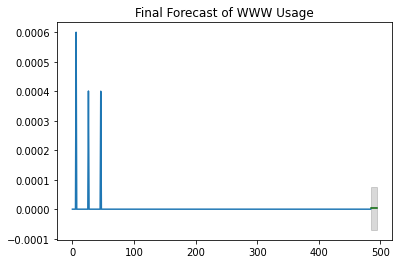

In [14]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
df = label_data
print(time.time())
model = pm.auto_arima(df.node_disk_discard_time_seconds_total, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(time.time())
print(model.summary())

# Forecast
n_periods = 10
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.node_disk_discard_time_seconds_total), len(df.node_disk_discard_time_seconds_total)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.node_disk_discard_time_seconds_total)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

# KNN

Index(['time', 'label', 'node_disk_discard_time_seconds_total',
       'node_disk_discarded_sectors_total',
       'node_disk_discards_completed_total', 'node_disk_discards_merged_total',
       'node_disk_io_now', 'node_disk_io_time_seconds_total',
       'node_disk_io_time_weighted_seconds_total',
       'node_disk_read_bytes_total', 'node_disk_read_time_seconds_total',
       'node_disk_reads_completed_total', 'node_disk_reads_merged_total',
       'node_disk_write_time_seconds_total',
       'node_disk_writes_completed_total', 'node_disk_writes_merged_total',
       'node_disk_written_bytes_total'],
      dtype='object')


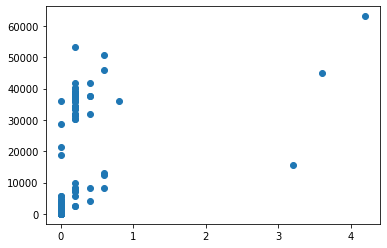

In [15]:
from sklearn.neighbors import NearestNeighbors

print(label_data.columns)
plt.scatter(label_data['node_disk_writes_merged_total'], label_data['node_disk_written_bytes_total'])    

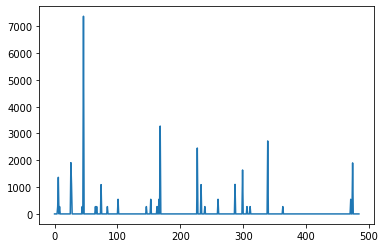

In [16]:
values = label_data.drop(['time'], axis=1).values
nbrs = NearestNeighbors(n_neighbors = 3)
nbrs.fit(values)

# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(values)
# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

In [17]:
# visually determine cutoff values > 0.15
outlier_index = np.where(distances.mean(axis = 1) > 0.15)
outlier_index
# filter outlier values
outlier_values = label_data.iloc[outlier_index]
outlier_values

,time,label,node_disk_discard_time_seconds_total,node_disk_discarded_sectors_total,node_disk_discards_completed_total,node_disk_discards_merged_total,node_disk_io_now,node_disk_io_time_seconds_total,node_disk_io_time_weighted_seconds_total,node_disk_read_bytes_total,node_disk_read_time_seconds_total,node_disk_reads_completed_total,node_disk_reads_merged_total,node_disk_write_time_seconds_total,node_disk_writes_completed_total,node_disk_writes_merged_total,node_disk_written_bytes_total
5,2021-05-18 13:07:15,0,0.000000,0.000000,0.000000,0.0,0.0,0.001600,0.000000,0.0,0.0,0.0,0.0,0.001000,8.000000,0.20000,34406.400000
6,2021-05-18 13:07:30,0,0.000600,6.400000,0.200000,0.0,0.0,0.005600,0.008800,0.0,0.0,0.0,0.0,0.012800,7.400000,3.60000,45056.000000
8,2021-05-18 13:08:00,0,0.000000,0.000000,0.000000,0.0,0.0,0.001600,0.000000,0.0,0.0,0.0,0.0,0.001000,8.000000,0.20000,38502.400000
16,2021-05-18 13:10:00,0,0.000000,0.000000,0.000000,0.0,0.0,0.000800,0.000000,0.0,0.0,0.0,0.0,0.001000,7.600000,0.20000,31948.800000
26,2021-05-18 13:12:30,0,0.000401,4.808656,0.200361,0.0,0.0,0.003206,0.001603,0.0,0.0,0.0,0.0,0.002004,0.601082,3.20577,15592.867161
27,2021-05-18 13:12:45,0,0.000000,0.000000,0.000000,0.0,0.0,0.001600,0.000000,0.0,0.0,0.0,0.0,0.001000,2.400000,0.60000,12288.000000
34,2021-05-18 13:14:30,0,0.000000,0.000000,0.000000,0.0,0.0,0.001600,0.000000,0.0,0.0,0.0,0.0,0.001600,8.400000,0.20000,37683.200000
44,2021-05-18 13:17:00,0,0.000000,0.000000,0.000000,0.0,0.0,0.001600,0.000000,0.0,0.0,0.0,0.0,0.001600,7.800000,0.20000,34406.400000
46,2021-05-18 13:17:30,0,0.000400,6.400000,0.200000,0.0,0.0,0.005600,0.001600,0.0,0.0,0.0,0.0,0.005800,10.600000,4.20000,63078.400000
49,2021-05-18 13:18:15,0,0.000000,0.000000,0.000000,0.0,0.0,0.000800,0.000000,0.0,0.0,0.0,0.0,0.001400,8.400000,0.20000,36044.800000


# Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))


(0.79, 0.5743243243243243, 0.496500372300819, None)
(0.6086956521739131, 0.6086956521739131, 0.6086956521739131, None)
(0.7730434782608695, 0.6086956521739131, 0.5156916701738483, None)


# SVM

In [50]:

import warnings
warnings.filterwarnings('ignore')

In [52]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# clf = svm.SVC()
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(label_data.drop(['time'], axis=1).to_numpy(), caliper_txn_failure)
clf.fit(X_train, y_train)

y_pred_numerical = clf.predict(X_test)

print("scores with numerical labels")
print(precision_recall_fscore_support(y_test_numerical, y_pred_numerical, average='macro'))
print(precision_recall_fscore_support(y_test_numerical, y_pred_numerical, average='micro'))
print(precision_recall_fscore_support(y_test_numerical, y_pred_numerical, average='weighted'))
# confusion_matrix(y_test, y_pred)



scores with numerical labels
(0.014974358974358974, 0.025294525294525295, 0.018812008761757506, None)
(0.453416149068323, 0.453416149068323, 0.453416149068323, None)
(0.2684223602484472, 0.453416149068323, 0.3372140204126221, None)


In [53]:
# clf = svm.SVC()
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(label_data.drop(['time'], axis=1).to_numpy(), caliper_txn_failure)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("scores with boolean labels")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
# confusion_matrix(y_test, y_pred)

scores with boolean labels
(0.7781111111111111, 0.6943926685305996, 0.6513870163827267, None)
(0.6708074534161491, 0.6708074534161491, 0.6708074534161491, None)
(0.7937846790890268, 0.6708074534161491, 0.6447431826607662, None)


In [54]:
label_data.drop(['time'], axis=1)

,label,node_disk_discard_time_seconds_total,node_disk_discarded_sectors_total,node_disk_discards_completed_total,node_disk_discards_merged_total,node_disk_io_now,node_disk_io_time_seconds_total,node_disk_io_time_weighted_seconds_total,node_disk_read_bytes_total,node_disk_read_time_seconds_total,node_disk_reads_completed_total,node_disk_reads_merged_total,node_disk_write_time_seconds_total,node_disk_writes_completed_total,node_disk_writes_merged_total,node_disk_written_bytes_total
0,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2
1,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2
2,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2
3,1,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2
4,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2
481,0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
482,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2
483,0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# DBSCAN
Density-Based Spatial Clustering of Applications with Noise

In [55]:
from sklearn.cluster import DBSCAN
import numpy as np
X = np.array([[1, 2], [2, 2], [2, 3],
              [8, 7], [8, 8], [25, 80]])
clustering = DBSCAN(eps=3, min_samples=2).fit(X_train.reshape(-1,1))
clustering.labels_

array([0, 0, 0, ..., 0, 0, 1])

In [62]:
clustering.fit(X_train, y_train)
y_pred = clustering.fit_predict(X_test)
print(y_pred)
clustering.get_params()
clustering.set_params()


[ 0  1  2  3  2  2  3  3  3  3  3  3  3  3 -1  3 -1  3  3  2  0  3  3  3
  3 -1  3  3  4  3  3  3  3  3  3  3  3  2  3  3  5  3  2  3  2  3  6  3
  3  3  3  3  2  3  2  3  3  7 -1  2  3  0  3  2  2  3  3  2  3  3  2  3
  3  2  1  3  3  3  0  3  3  0  3  3  3  3  3  3  3  3  2  5  2  3  3  3
  3  3  3  2  7  3  3  3  7  3  3  2  3  3  3  3  3  2  3 -1  3  3  3  3
  3  3  3 -1  3  3  0  3  2  3  3  2  5  3  2  3  3  2  3 -1  3  3  4  2
  3  3  3  3  3  3  3  2  3  3  3 -1  3  3  6  3 -1]


DBSCAN(eps=3, min_samples=2)

# VAR 

In [204]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

dates = processed_df['time']

processed_df.index = dates
processed_df = processed_df.drop(['time', 'label','bool_caliper_txn_failure'], axis=1)

In [216]:
#TODO only select columns if it has other values than 0
# TODO split train and test set -> make predictions -> compare with test
# -> if difference ...% -> anomaly
data = (processed_df[['node_disk_writes_completed_total', 'node_disk_written_bytes_total']]).diff().dropna()

# model = VAR(np.asarray(data))
model = VAR(data)

In [217]:
results = model.fit()

In [218]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, May, 2021
Time:                     12:58:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.7901
Nobs:                     483.000    HQIC:                   16.7585
Log likelihood:          -5406.95    FPE:                1.85900e+07
AIC:                      16.7381    Det(Omega_mle):     1.83612e+07
--------------------------------------------------------------------
Results for equation node_disk_writes_completed_total
                                         coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------
const                                      -0.000208         0.130178           -0.002           0.999
L1.node_disk_writes_completed_total        -0.23

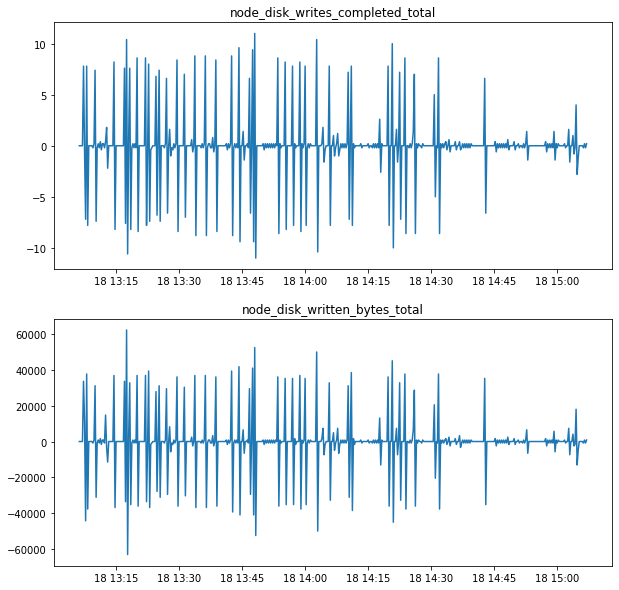

In [219]:
results.plot()
plt.show()

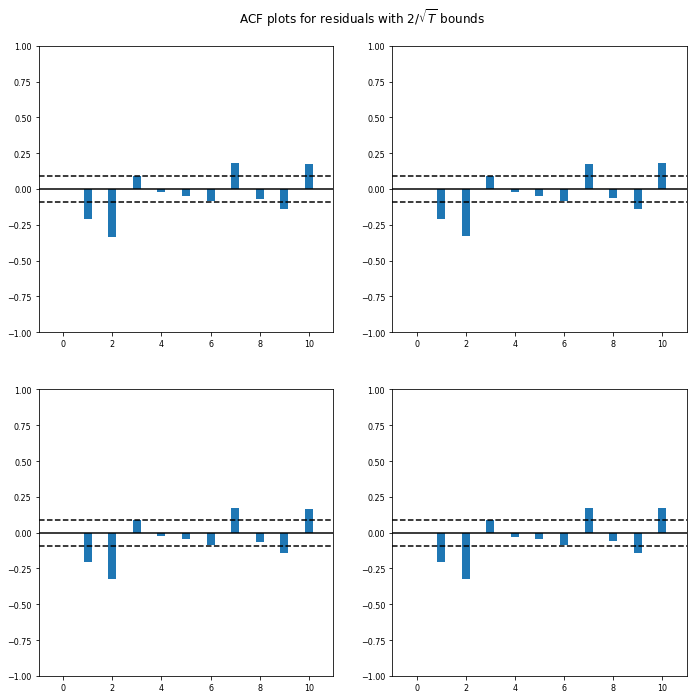

In [220]:
results.plot_acorr()
plt.show()

In [221]:
model.select_order(15)

In [222]:
results = model.fit(maxlags=25, ic='aic')

In [223]:
lag_order = results.k_ar
results.forecast(data.values[-lag_order:], 5)

array([[ 4.53568401e-01,  2.05713272e+03],
       [ 1.53657724e-01,  6.97013065e+02],
       [-3.41265525e-01, -1.46229206e+03],
       [-6.38864782e-02, -3.98397480e+02],
       [ 3.26738916e-02,  1.84049756e+02]])

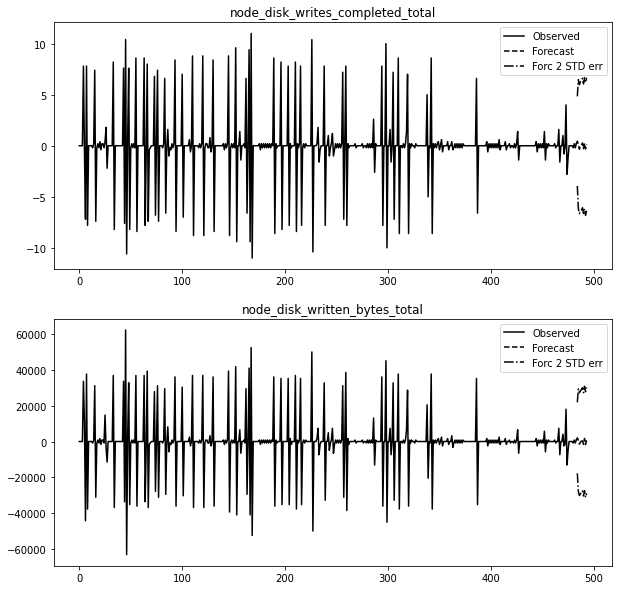

In [224]:
results.plot_forecast(10)
plt.show()

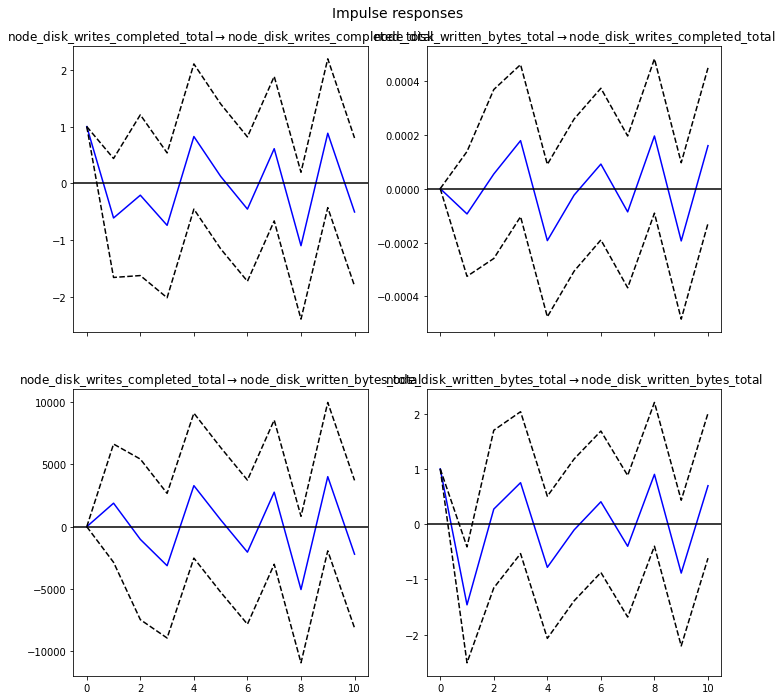

In [225]:
irf = results.irf(10)
irf.plot(orth=False)
plt.show()

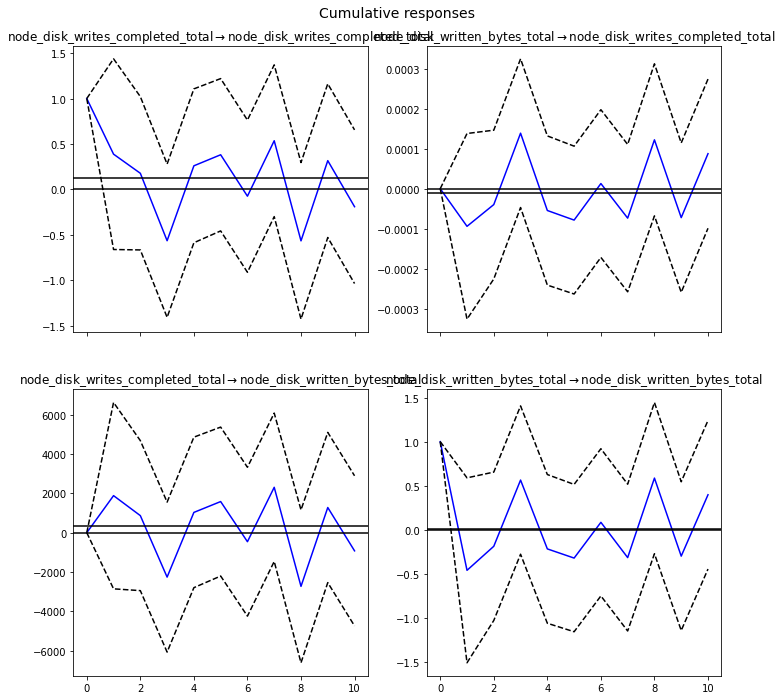

In [227]:
irf.plot_cum_effects(orth=False)
plt.show()

In [230]:
fevd = results.fevd(5)
fevd.summary()

FEVD for node_disk_writes_completed_total
     node_disk_writes_completed_total  node_disk_written_bytes_total
0                            1.000000                       0.000000
1                            0.999293                       0.000707
2                            0.999058                       0.000942
3                            0.996529                       0.003471
4                            0.993583                       0.006417

FEVD for node_disk_written_bytes_total
     node_disk_writes_completed_total  node_disk_written_bytes_total
0                            0.991874                       0.008126
1                            0.987837                       0.012163
2                            0.987565                       0.012435
3                            0.985431                       0.014569
4                            0.983135                       0.016865




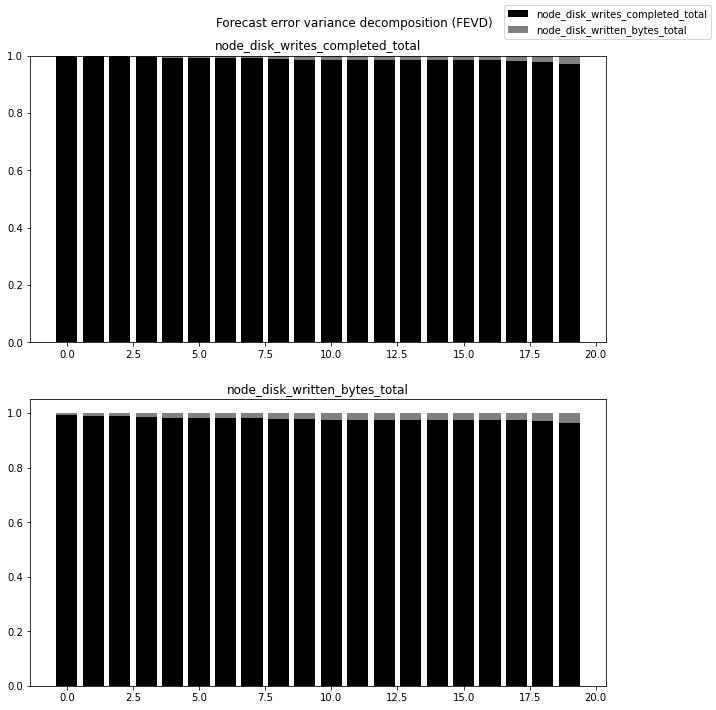

In [231]:
results.fevd(20).plot()
plt.show()

In [235]:
print(results.test_causality('node_disk_writes_completed_total', ['node_disk_writes_completed_total', 'node_disk_written_bytes_total'], kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['node_disk_writes_completed_total', 'node_disk_written_bytes_total'] do not Granger-cause node_disk_writes_completed_total: reject at 5% significance level. Test statistic: 15.028, critical value: 1.409>, p-value: 0.000>


In [234]:
print(results.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 34079.079, critical value: 9.488>, p-value: 0.000>
